In [49]:
import tensorflow as tf
print(tf.__version__)
import cv2
from pathlib import Path
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import PIL
import os

2.15.0


In [11]:
local_dataset_path = "C:/Users/joeul/Machine learning model/train"
data_dir = Path(local_dataset_path)
image_count = len(list(data_dir.glob('*/*.png')))


In [12]:
print(image_count)

23650


In [17]:
angry = list(data_dir.glob('angry/*'))
disgusted = list(data_dir.glob('disgusted/*'))
fearful = list(data_dir.glob('fearful/*'))
happy = list(data_dir.glob('happy/*'))
neutral = list(data_dir.glob('neutral/*'))
sad = list(data_dir.glob('sad/*'))
surprised = list(data_dir.glob('surprised/*'))

In [18]:
batch_size = 32
img_height = 180
img_width = 180

In [19]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


In [20]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


In [21]:
class_names = train_ds.class_names
print(class_names)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


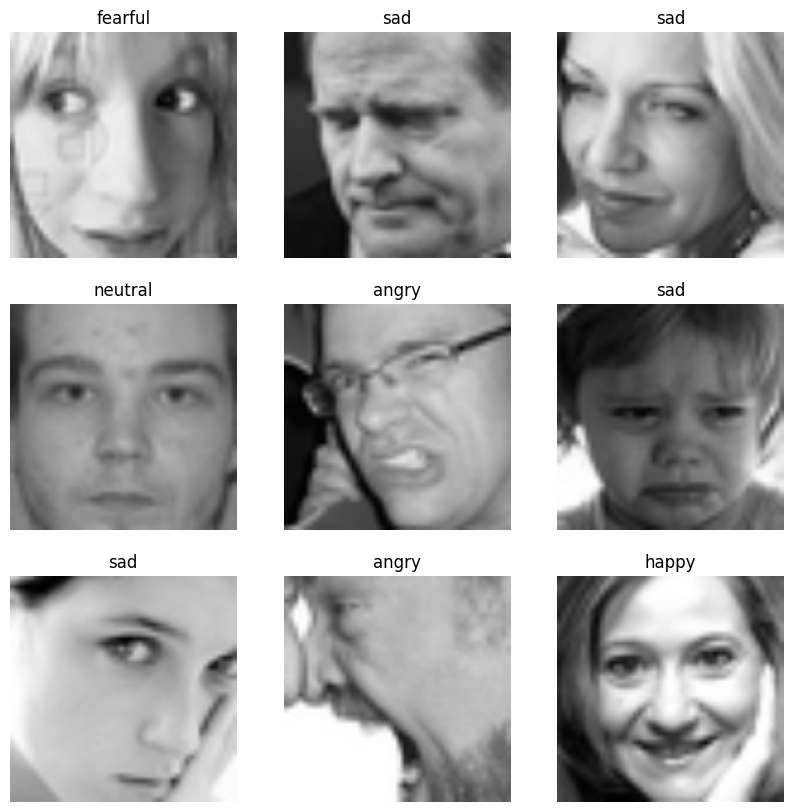

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [23]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [30]:
normalization_layer =  tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.907808


In [33]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [36]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


718/718 [==============================] - 155s 213ms/step - loss: 1.6507 - accuracy: 0.3468 - val_loss: 1.5108 - val_accuracy: 0.4221
Epoch 2/10
718/718 [==============================] - 167s 232ms/step - loss: 1.3937 - accuracy: 0.4623 - val_loss: 1.3927 - val_accuracy: 0.4694
Epoch 3/10
718/718 [==============================] - 160s 223ms/step - loss: 1.2268 - accuracy: 0.5324 - val_loss: 1.3736 - val_accuracy: 0.4827
Epoch 4/10
718/718 [==============================] - 179s 250ms/step - loss: 1.0194 - accuracy: 0.6212 - val_loss: 1.4579 - val_accuracy: 0.4825
Epoch 5/10
718/718 [==============================] - 179s 250ms/step - loss: 0.7428 - accuracy: 0.7277 - val_loss: 1.5979 - val_accuracy: 0.4909
Epoch 6/10
718/718 [==============================] - 164s 229ms/step - loss: 0.4502 - accuracy: 0.8408 - val_loss: 2.0529 - val_accuracy: 0.4776
Epoch 7/10
718/718 [==============================] - 158s 220ms/step - loss: 0.2445 - accuracy: 0.9185 - val_loss: 2.6151

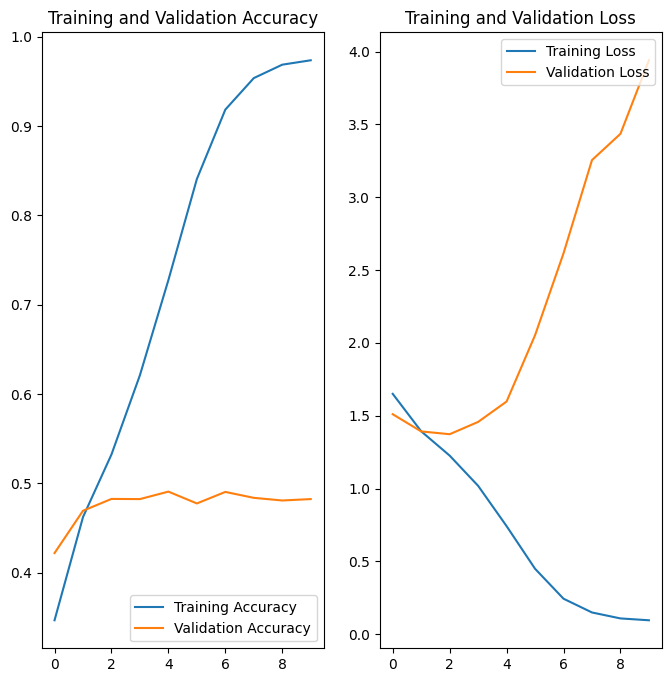

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# ADDING AUGMENTATION AND DROPOUT TO IMPROVE ACCURACY #

In [39]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

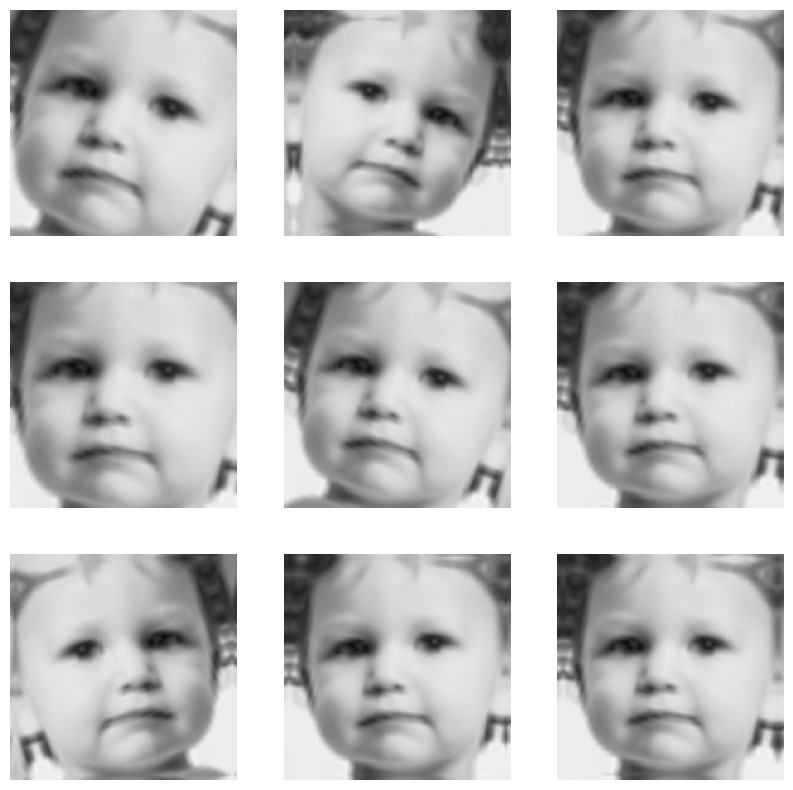

In [40]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [41]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [53]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model.save_weights(checkpoint_path.format(epoch=0))


In [43]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[cp_callback]
)

Epoch 1/15
718/718 [==============================] - 221s 304ms/step - loss: 1.7797 - accuracy: 0.2663 - val_loss: 1.7215 - val_accuracy: 0.2932
Epoch 2/15
718/718 [==============================] - 238s 332ms/step - loss: 1.6996 - accuracy: 0.3150 - val_loss: 1.6232 - val_accuracy: 0.3665
Epoch 3/15
718/718 [==============================] - 211s 294ms/step - loss: 1.5971 - accuracy: 0.3784 - val_loss: 1.5133 - val_accuracy: 0.4173
Epoch 4/15
718/718 [==============================] - 201s 280ms/step - loss: 1.5197 - accuracy: 0.4100 - val_loss: 1.4662 - val_accuracy: 0.4342
Epoch 5/15
718/718 [==============================] - 198s 276ms/step - loss: 1.4777 - accuracy: 0.4274 - val_loss: 1.4393 - val_accuracy: 0.4447
Epoch 6/15
718/718 [==============================] - 202s 281ms/step - loss: 1.4388 - accuracy: 0.4456 - val_loss: 1.4233 - val_accuracy: 0.4534
Epoch 7/15
718/718 [==============================] - 200s 279ms/step - loss: 1.4027 - accuracy: 0.4606 - val_loss: 1.3916 -

In [54]:
os.listdir(checkpoint_dir)


['checkpoint', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

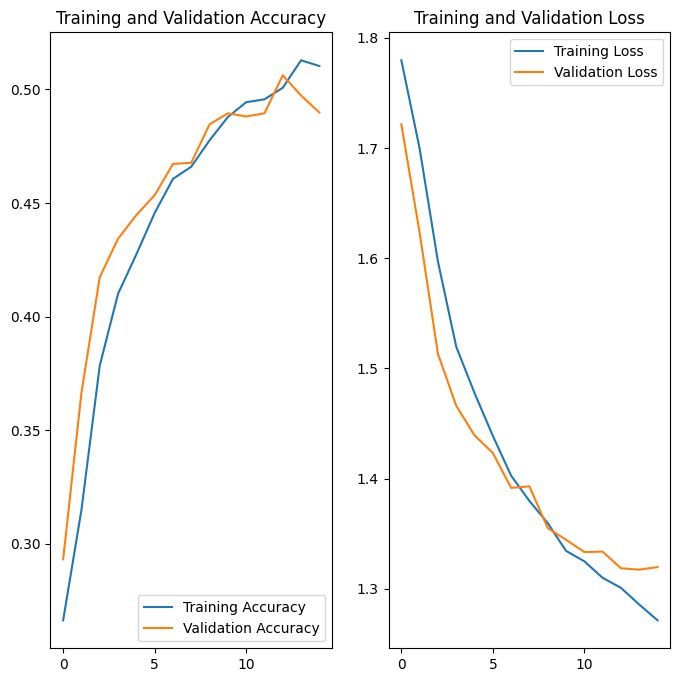

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [56]:
!mkdir -p saved_model
model.save('emotion.model')

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


INFO:tensorflow:Assets written to: emotion.model\assets


INFO:tensorflow:Assets written to: emotion.model\assets
